In [1]:
# https://pypi.tuna.tsinghua.edu.cn/simple
import anndata as ad
import scanpy as sc
import squidpy as sq
import cellcharter as cc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warn(f"Failed to load image Python extension: {e}")


In [2]:
rnadata = sc.read_h5ad("./RNA/spatial.combined.bin100.h5")
guide_genes = rnadata.var_names[~rnadata.var_names.str.startswith('sg')]
rnadata = rnadata[:, guide_genes].copy()

In [3]:
from bin import utils
rnadata = utils.remove_mito_ribo_hk_lnc_genes(rnadata).copy()
sc.pp.filter_cells(rnadata, min_counts=3)
sc.pp.filter_cells(rnadata, min_genes=3)
#rnadata.layers["counts"] = rnadata.X.copy()
#sc.pp.normalize_total(rnadata)
#sc.pp.log1p(rnadata)

In [4]:
rnadata.obs['x'] = rnadata.obsm['spatial'][:, 0]
rnadata.obs['y'] = rnadata.obsm['spatial'][:, 1]

In [5]:
retained_bins = ((rnadata.obs['marker'] == 'A') & (rnadata.obs['y'] > 4000)) | ((rnadata.obs['marker'] == 'B') & (rnadata.obs['y'] < 6500))
retained_data = rnadata[retained_bins].copy()

In [6]:
import scvi

scvi.settings.seed = 114514
scvi.model.SCVI.setup_anndata(retained_data, batch_key="marker")
model=scvi.model.SCVI(retained_data, n_hidden=32, n_latent=10, n_layers=5, gene_likelihood="poisson", latent_distribution="normal")

model.train(early_stopping=True, enable_progress_bar=True)
model.save("/home/wpy/stereoseq/20240702-Exclusive/scvi.retained.model", save_anndata=True, overwrite=True)

Global seed set to 0


Global seed set to 114514
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


KeyboardInterrupt: 

In [6]:
import scvi
model = scvi.model.SCVI.load("/home/wpy/stereoseq/20240702-Exclusive/scvi.retained.model")

Global seed set to 0


INFO     File /home/wpy/stereoseq/20240702-Exclusive/scvi.retained.model/model.pt already downloaded               


/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


In [7]:
retained_data.obsm["X_scVI"] = model.get_latent_representation(retained_data).astype(np.float32)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


In [8]:
retained_data.obs["marker"] = retained_data.obs["marker"].astype("category")

In [9]:
sq.gr.spatial_neighbors(retained_data, library_key="marker", coord_type="generic", delaunay=False, spatial_key="spatial", radius=120)

In [10]:
cc.gr.remove_long_links(retained_data)

In [11]:
cc.gr.aggregate_neighbors(retained_data, n_layers=3, use_rep="X_scVI", out_key="X_cellcharter", sample_key="marker")

100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


In [15]:
autok = cc.tl.ClusterAutoK(
    n_clusters = (2,15),
    max_runs = 10,
    model_params = dict(
        random_state = 114514
    )
)

In [16]:
autok.fit(retained_data, use_rep="X_cellcharter")

Iteration 1/10


  0%|          | 0/16 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  6%|▋         | 1/16 [00:00<00:02,  5.46it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 12%|█▎        | 2/16 [00:01<00:09,  1.48it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 2/10


  0%|          | 0/16 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  6%|▋         | 1/16 [00:00<00:01,  7.72it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 12%|█▎        | 2/16 [00:00<00:04,  2.87it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 3/10


  0%|          | 0/16 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  6%|▋         | 1/16 [00:00<00:02,  7.44it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 12%|█▎        | 2/16 [00:00<00:06,  2.19it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 4/10


  0%|          | 0/16 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  6%|▋         | 1/16 [00:00<00:01,  9.12it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 12%|█▎        | 2/16 [00:00<00:06,  2.27it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 5/10


  0%|          | 0/16 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  6%|▋         | 1/16 [00:00<00:01,  8.61it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 12%|█▎        | 2/16 [00:00<00:05,  2.37it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 6/10


  0%|          | 0/16 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  6%|▋         | 1/16 [00:00<00:01,  7.83it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 12%|█▎        | 2/16 [00:00<00:06,  2.28it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 7/10


  0%|          | 0/16 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  6%|▋         | 1/16 [00:00<00:01,  9.79it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 12%|█▎        | 2/16 [00:00<00:06,  2.23it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Convergence with a change in stability of 0.00982022131421066 reached after 7 iterations


In [16]:
givenk = cc.tl.Cluster(n_clusters=3)
givenk.fit(retained_data, use_rep="X_cellcharter")
retained_data.obs["cluster"] = givenk.predict(retained_data, use_rep="X_cellcharter")

/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(


In [17]:
retained_data.obs["cluster"] = givenk.predict(retained_data, use_rep="X_cellcharter")

In [18]:
del retained_data.uns['cluster_colors']

/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/ho

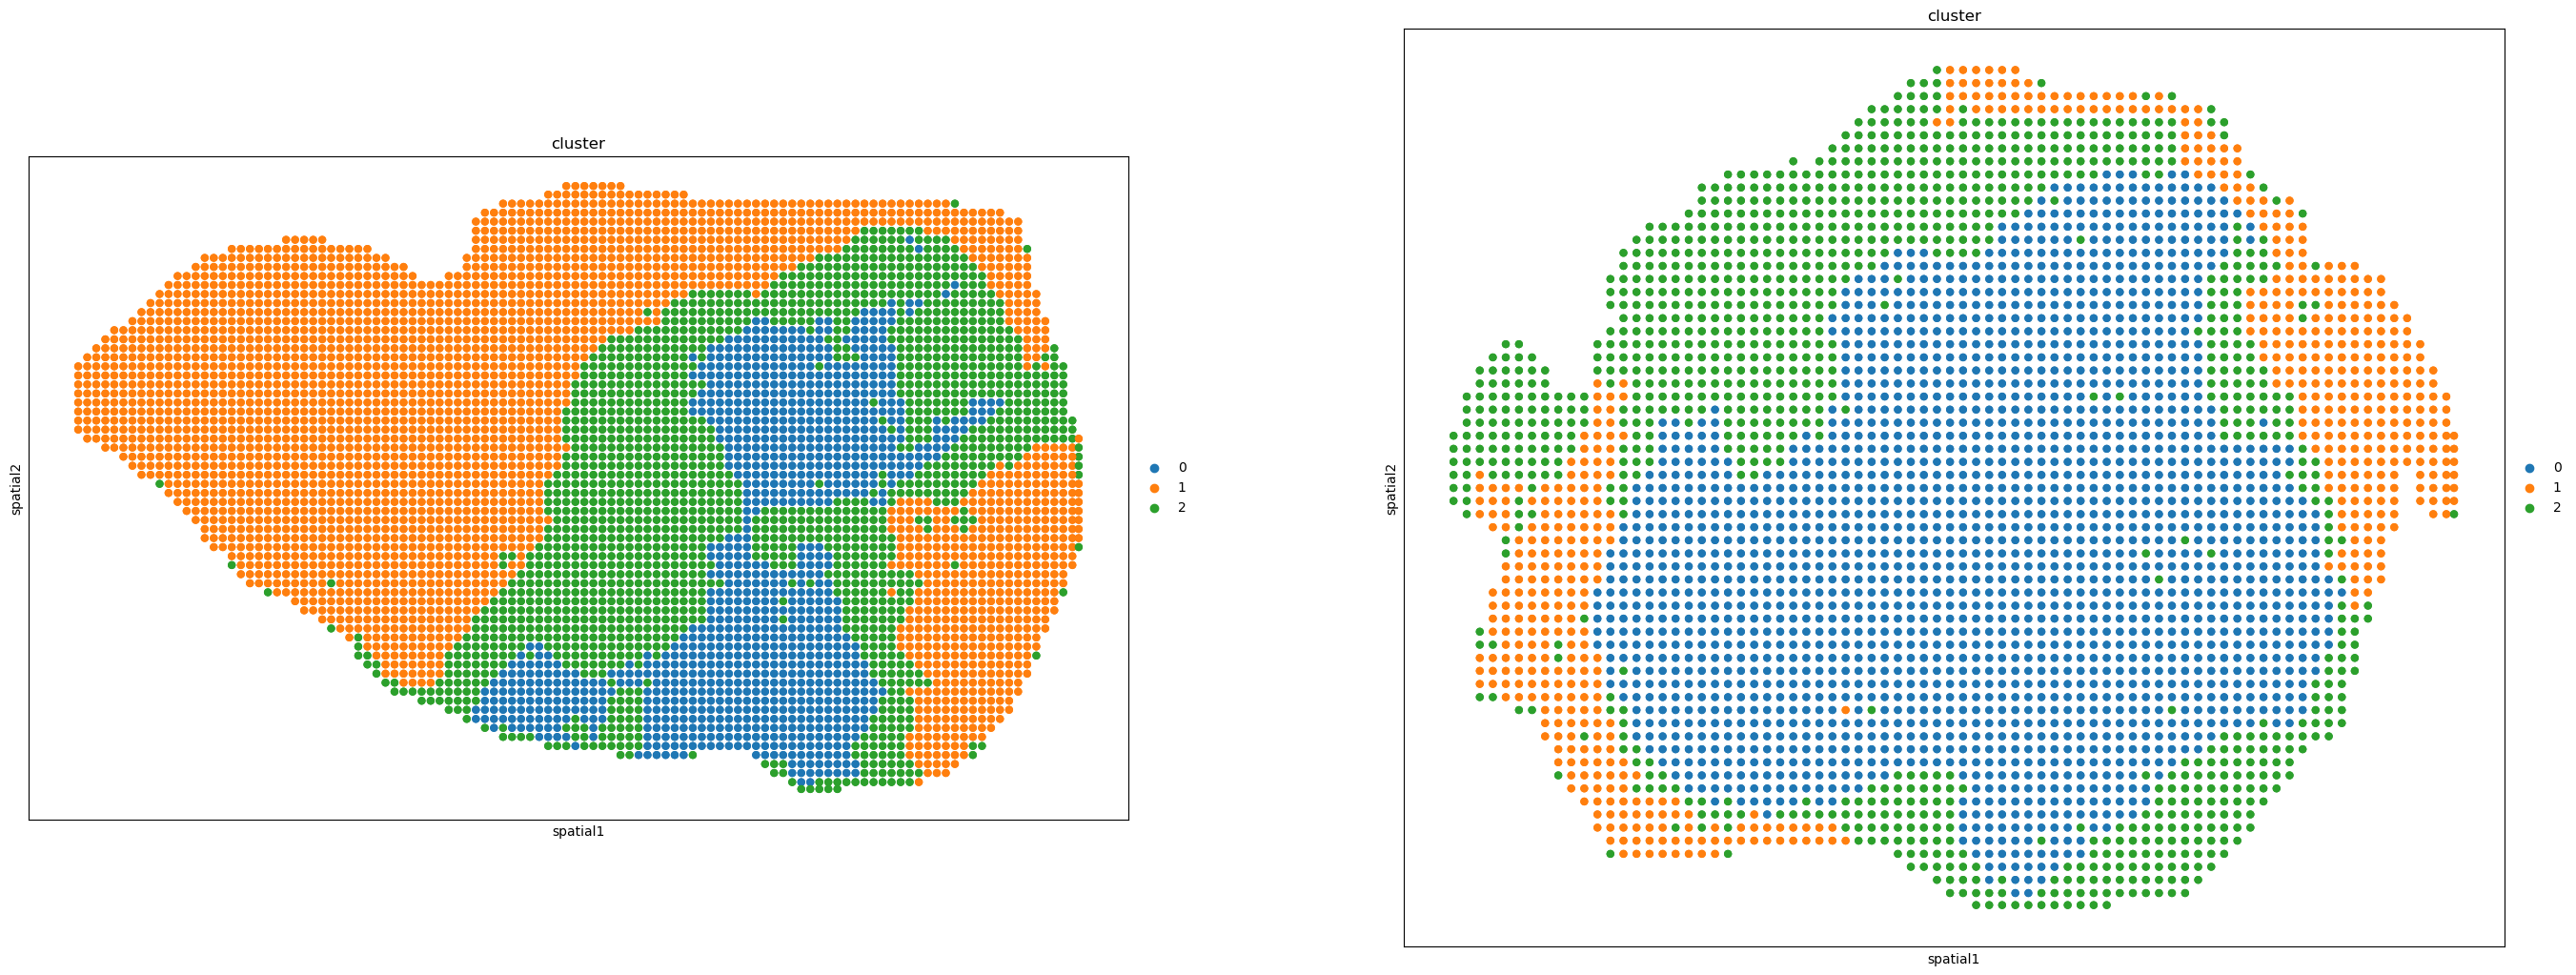

In [19]:
sq.pl.spatial_scatter(
    retained_data, 
    color=['cluster'], 
    library_key='marker',  
    size=100, 
    img=None,
    spatial_key='spatial',
    cmap='Set2',
    #connectivity_key='spatial_connectivities',
    #img_alpha=0.3,
    figsize=(15,15),
    ncols=2,
    shape=None
)

In [30]:
retained_data.layers["counts"] = retained_data.X.copy()

sc.pp.normalize_total(retained_data)
sc.pp.log1p(retained_data)

/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/ho

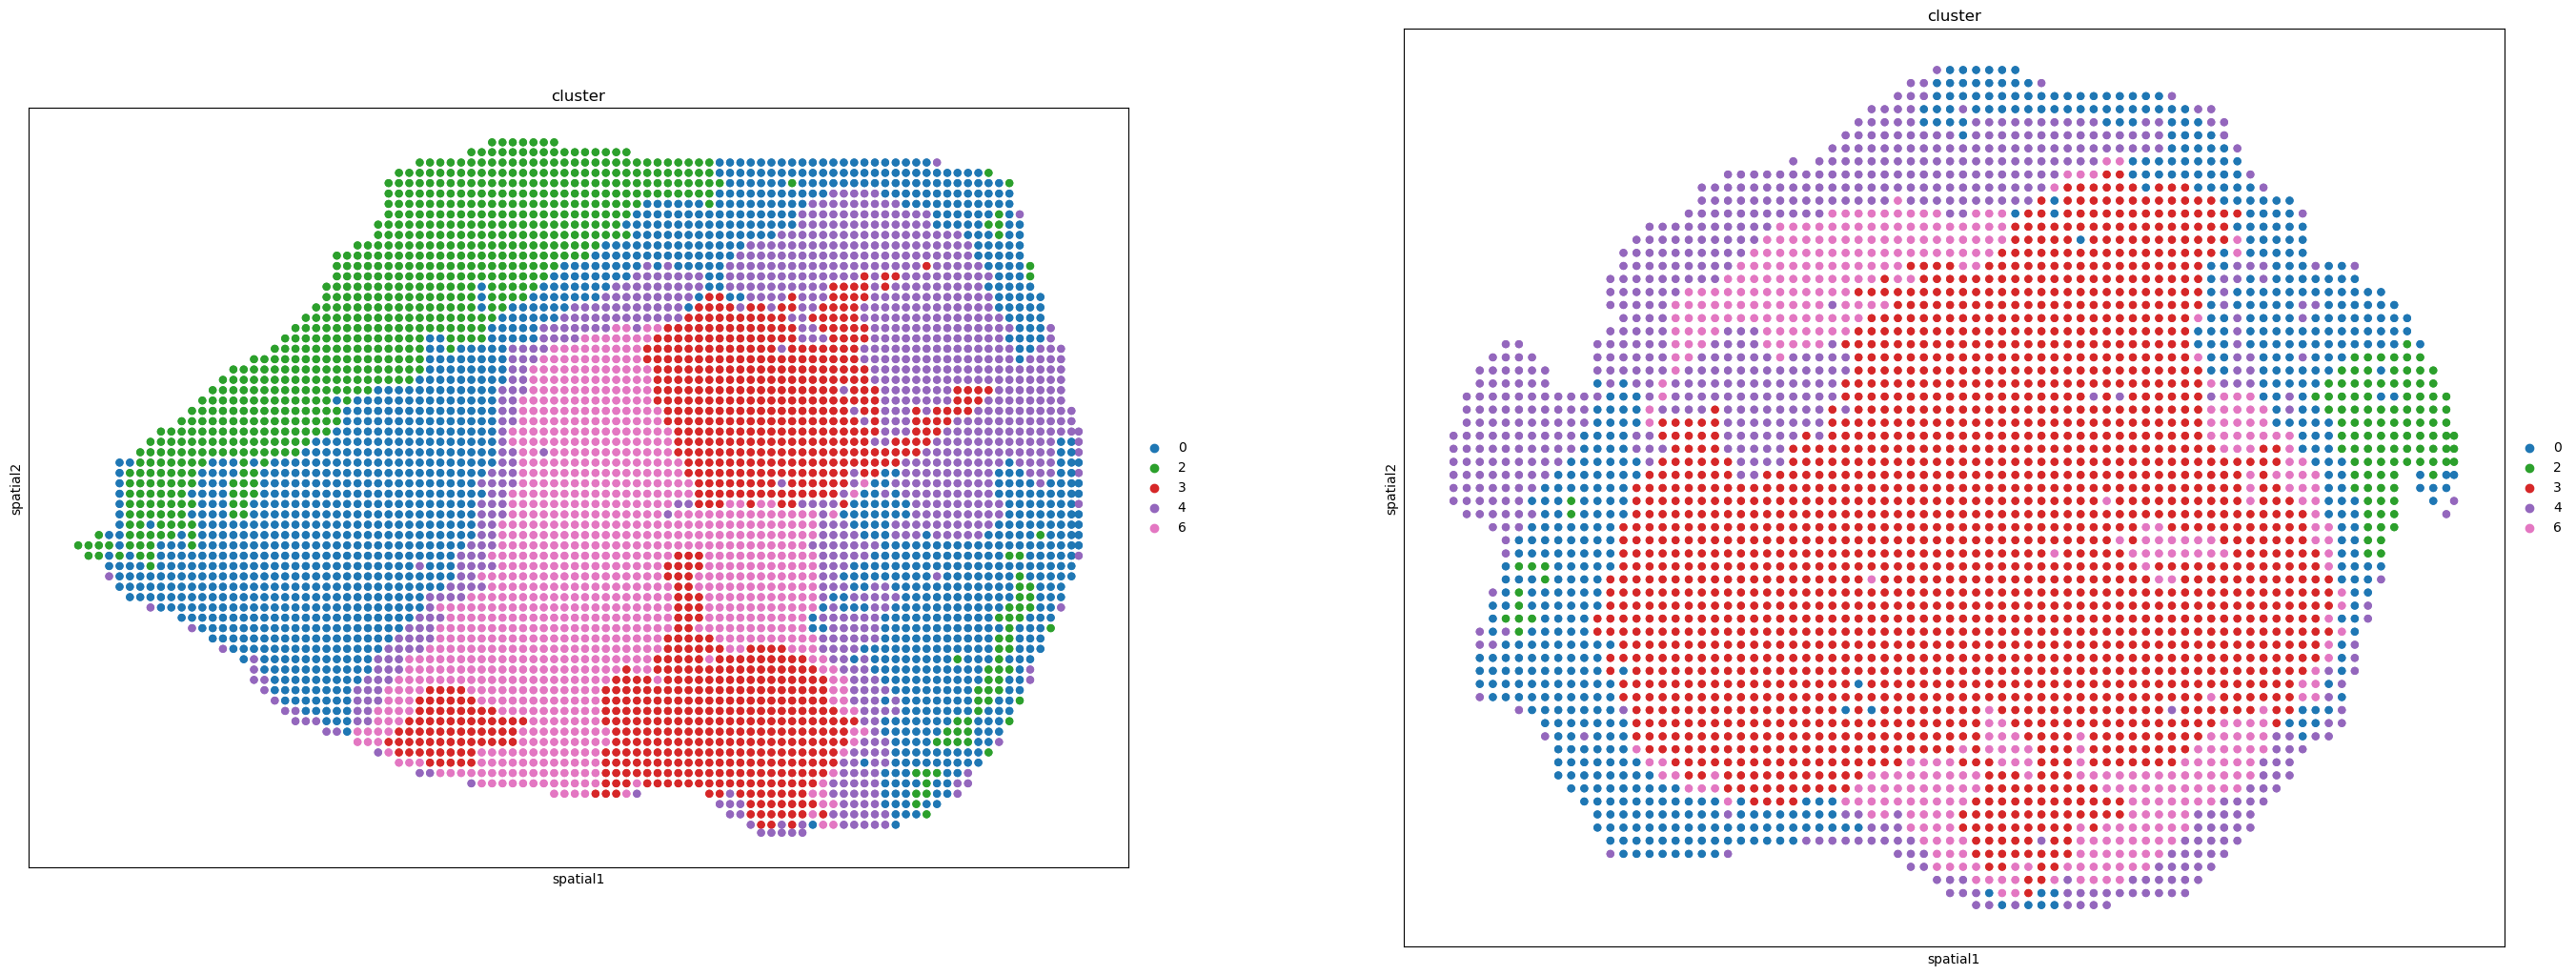

In [31]:
retained_data = retained_data[(retained_data.obs['cluster'] != 1) & (retained_data.obs['cluster'] != 5)].copy()
sq.pl.spatial_scatter(
    retained_data, 
    color=['cluster'], 
    library_key='marker',  
    size=100, 
    img=None,
    spatial_key='spatial',
    cmap='Set2',
    #connectivity_key='spatial_connectivities',
    #img_alpha=0.3,
    figsize=(15,15),
    ncols=2,
    shape=None
)

In [32]:
retained_data.write_h5ad("./RNA/reclustered.h5")

In [22]:
retained_data.obs['type'] = retained_data.obs['cluster'].apply(lambda x: 'fibro' if x == 1 else 'tumor')

In [24]:
sc.tl.rank_genes_groups(retained_data, groupby="type", method='t-test')

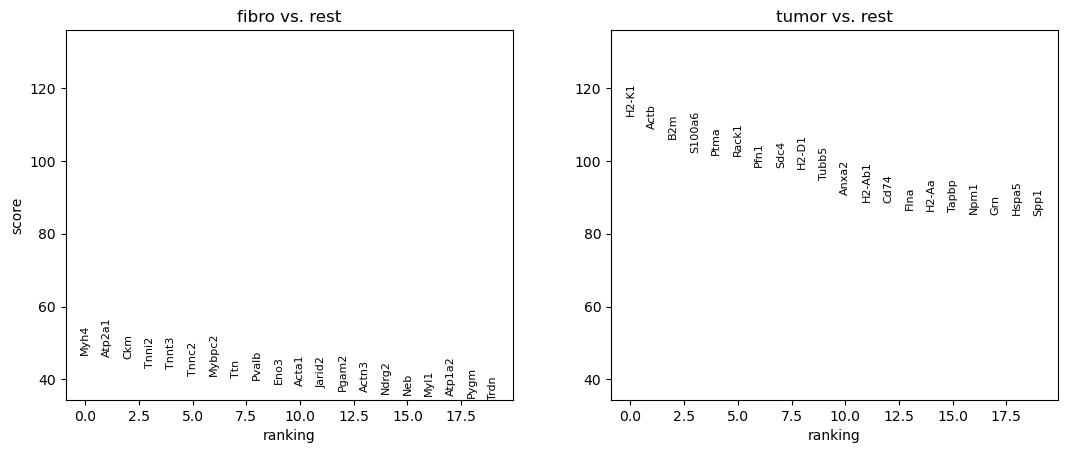

In [25]:
sc.pl.rank_genes_groups(retained_data, n_genes=20)

In [38]:
pval_cutoff = 0.01
top_n = 50

result = retained_data.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_genes_df = pd.DataFrame()

for group in groups:
    genes = result['names'][group]
    log2fc = result['logfoldchanges'][group]
    padj = result['pvals_adj'][group]
    score = result['scores'][group]
    
    data = pd.DataFrame({
        'Gene': genes,
        'Log2FoldChange': log2fc,
        'padj': padj,
        'score': score,
        'Cluster': group
    })
    
    filtered_data = data[data['padj'] < pval_cutoff]
    sorted_data = filtered_data.sort_values(by='score', ascending=False)
    top_genes = sorted_data.head(top_n)
    top_genes_df = pd.concat([top_genes_df, top_genes], ignore_index=True)

deg = top_genes_df["Gene"].unique().tolist()
# top_genes_df.to_csv('../20240502-SPACseq/DEG.csv', index=False, sep="\t")
top_genes_df

,Gene,Log2FoldChange,padj,score,Cluster
0,Acta1,2.152356,0.000000e+00,47.133980,0
1,Tnnt3,2.085449,1.906315e-301,40.914185,0
2,Tnni2,2.218070,2.381219e-297,40.590530,0
3,Myh1,2.333670,6.040882e-285,40.137760,0
4,Atp2a1,2.152122,4.131945e-286,39.788445,0
...,...,...,...,...,...
245,Itm2b,0.637082,3.464708e-164,29.063190,6
246,Snrpg,0.998271,2.599404e-158,28.971802,6
247,Sh3bgrl3,0.675972,1.390615e-164,28.917782,6
248,Fkbp1a,0.680716,3.659642e-161,28.693403,6
